In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import os
import shutil
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

use_gpu = torch.cuda.is_available()

#Разделение по папкам

In [ ]:

# Путь к главной папке, содержащей все изображения
main_folder_path = 'images/images/'

# Создать папки для каждого класса, если они не существуют
for class_name in data['class_id'].unique():
    class_folder_path = os.path.join(main_folder_path, str(class_name))
    if not os.path.exists(class_folder_path):
        os.makedirs(class_folder_path)

SIZE_DELETE = 1000
# Перенести каждую картинку из главной папки в папку класса, если она существует в DataFrame pandas
for index, row in tqdm(data.iterrows(),total=data.shape[0]):
    image_name = row['image']
    class_name = row['class_id']
    source_path = os.path.join(main_folder_path, image_name)
    if os.path.getsize(source_path) < SIZE_DELETE:
        os.remove(source_path)
    dest_folder_path = os.path.join(main_folder_path, str(class_name))
    dest_path = os.path.join(dest_folder_path, image_name)
    if os.path.exists(source_path):
        shutil.move(source_path, dest_path)


## Разделение на train и val

In [ ]:
!pip install split-folders 

In [ ]:
import splitfolders

input_folder = "./images/train"
splitfolders.ratio(input_folder, 'train_test', ratio = (0.8, 0.2), seed=42, group_prefix=None)

# Модель

## Готовые train и val

In [ ]:
!unzip drive/MyDrive/CLEANCODECUP/train_test.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train_test/val/4139/X9f2sOk3dyAGVMtlPwJDpmzE1UxBhnZqKI0576oR.jpg  
  inflating: train_test/val/413/9RH1C2lLFyre7uaYSjIp0GJdKDkcTPzM4vnZfhqV.jpg  
   creating: train_test/val/414/
   creating: train_test/val/4140/
  inflating: train_test/val/4140/3CRsuSGrdXjVkghNvybYHWcTf8AaJxtKIU67EmQ0.jpg  
  inflating: train_test/val/4140/bQXpoHYk8DcnVICg9r1iTUWjmf4lwsLyhZaENqSA.jpg  
   creating: train_test/val/4142/
  inflating: train_test/val/4142/xvw1QZMN87tn6ujWLROcb3IihGXEBsATH5Vdzfp0.jpg  
   creating: train_test/val/4143/
  inflating: train_test/val/4143/CmuW18PejczUYKbGIgthNS9AT4w5yHEZBRn3QoiV.jpg  
   creating: train_test/val/4145/
  inflating: train_test/val/4145/uaS6vAPqQjx1ln90cKDwJO7HIUkhGtTsVbz5YrN8.jpg  
   creating: train_test/val/4146/
  inflating: train_test/val/4146/0sN3e7XzjgJiwHvhF6q2YxBoEbZCmGDPRS1Qakt5.jpg  
   creating: train_test/val/4147/
  inflating: train_test/val/4147/CYLUJxtqXdrfsOPZApg2o3j

In [ ]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = './train_test'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
# # специальный класс для загрузки данных в виде батчей
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
#                                               shuffle=True, num_workers=2)
#                for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes



In [ ]:
full_dataset = datasets.ImageFolder(os.path.join('./train'),
                                          data_transforms['train'])
train_dataset, val_dataset = random_split(full_dataset, [int(0.7*len(full_dataset)), 
                                                len(full_dataset) - int(0.7*len(full_dataset))])

In [ ]:
dataloaders = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                              shuffle=True, num_workers=2),
               'val': torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                              shuffle=True, num_workers=2)}
dataset_sizes = {'train': len(train_dataset),'val':len(val_dataset)}
class_names = full_dataset.classes

In [ ]:
dataset_sizes

{'train': 33098, 'val': 14186}

## разделять train 

In [ ]:
import os
import albumentations as A
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split

In [ ]:
!unzip drive/MyDrive/CLEANCODECUP/train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/770/zJM32bxtfCPQZ1gjeYlvDhXS5wAHraOokNmE7yqT.jpg  
   creating: train/771/
  inflating: train/771/0HVQOdnLk5W2pU7zsiXfvD91lhxcKPqo4ebSuTCa.jpg  
  inflating: train/771/2vMVAwxf9sOIH0QZgoXYK5azbyLlJBCeqncSPjFu.jpg  
  inflating: train/771/32T5h0JNXxk9cmjEPulCwRzLQof4Zq8s6WBYHeb1.jpg  
  inflating: train/771/4CV9e0njJcU85ANhptfDRBGwrS7qHiaxbWOzIM3Q.jpg  
  inflating: train/771/6x7l2iHKzonfXjgq5k0BA9GFdYDtsrVJWEh4IMmw.jpg  
  inflating: train/771/goRPmcEVnLkBAKSX3OQafD6w8TC4xYZ1MvlIdzui.jpg  
  inflating: train/771/lZ7HdPmvhCbqQw8MnxFos501DKuWGzpSL9fBXO6E.jpg  
  inflating: train/771/n2fWXpxgi7h6bmFMdIEvaeAcsKo3VY4HljBSJuLZ.jpg  
  inflating: train/771/SnecIKiz23YHVNuhyZdCEW1RLvMJDA7fatjqGmxb.jpg  
  inflating: train/771/UzybktBp9F6dhwcXurM7LnfWiIVx5HT2a1YD4AqE.jpg  
   creating: train/772/
  inflating: train/772/1CQNKxwrSf2tiRJbMY8zG3XEDoul6aULW9gh5dBA.jpg  
  inflating: train/772/7mjVQeExntWCOvJ84og9d

In [ ]:
class ImageFolder(Dataset):
    def __init__(self, root_dir, transform=None, total_classes=None):
        self.transform = transform
        self.data = []
        
        if total_classes:
            self.classnames  = os.listdir(root_dir)[:total_classes] # for test
        else:
            self.classnames = os.listdir(root_dir)
            
        for index, label in enumerate(self.classnames):
            root_image_name = os.path.join(root_dir, label)
            
            for i in os.listdir(root_image_name):
                full_path = os.path.join(root_image_name, i)
                self.data.append((full_path, index))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data, target = self.data[index]
        img = np.array(Image.open(data))
        
        if self.transform:
            augmentations = self.transform(image=img)
            img = augmentations["image"]
        
        target = torch.from_numpy(np.array(target))
        img = np.transpose(img, (2, 0, 1))
        img = torch.from_numpy(img)            
        
        return img, target

In [ ]:
SIZE = 244
SIZE2 = 256

train_transform_alb = A.Compose(
    [
        A.Resize(SIZE2, SIZE2),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(SIZE, SIZE),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

train_transform_base = A.Compose(
    [
        A.Resize(SIZE2, SIZE2),
        A.CenterCrop(SIZE, SIZE),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]
)

In [ ]:
train_set_dir = './train'

alb_set = ImageFolder(train_set_dir, transform=train_transform_alb)
base_set = ImageFolder(train_set_dir, transform=train_transform_base)

full_dataset = alb_set + base_set

In [ ]:
train_dataset, val_dataset = random_split(full_dataset, [int(0.7*len(full_dataset)), 
                                                len(full_dataset) - int(0.7*len(full_dataset))])

In [ ]:
train_loaders = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loaders = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

dataloaders = {'train':train_loaders, 'val':val_loaders}

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = (iter(dataloaders['train']).next())

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

AttributeError: ignored

## Обучение модели

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
   
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                try:
                    # получаем картинки и метки
                    inputs, labels = data

                    # оборачиваем в переменные
                    if use_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    else:
                        inputs, labels = inputs, labels

                    # инициализируем градиенты параметров
                    if phase=="train":
                        optimizer.zero_grad()

                    # forward pass
                    if phase == "eval":
                        with torch.no_grad():
                            outputs = model(inputs)
                    else:
                        outputs = model(inputs)
                    preds = torch.argmax(outputs, -1)
                    loss = criterion(outputs, labels)

                  
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    
                    running_loss += loss.item()
                    running_corrects += int(torch.sum(preds == labels.data))
                except Exception:
                    pass

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [ ]:
model_extractor = models.efficientnet_b0(pretrained=True)

# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

model_extractor.classifier = nn.Linear(in_features=1280, out_features=len(class_names))

if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_extractor.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch::   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train iter::   0%|          | 0/518 [00:00<?, ?it/s]

val iter::   0%|          | 0/222 [00:00<?, ?it/s]

train iter::   0%|          | 0/518 [00:00<?, ?it/s]

val iter::   0%|          | 0/222 [00:00<?, ?it/s]

train iter::   0%|          | 0/518 [00:00<?, ?it/s]

val iter::   0%|          | 0/222 [00:00<?, ?it/s]

train iter::   0%|          | 0/518 [00:00<?, ?it/s]

val iter::   0%|          | 0/222 [00:00<?, ?it/s]

train iter::   0%|          | 0/518 [00:00<?, ?it/s]

val iter::   0%|          | 0/222 [00:00<?, ?it/s]

train iter::   0%|          | 0/518 [00:00<?, ?it/s]

val iter::   0%|          | 0/222 [00:00<?, ?it/s]

train iter::   0%|          | 0/518 [00:00<?, ?it/s]

val iter::   0%|          | 0/222 [00:00<?, ?it/s]

train iter::   0%|          | 0/518 [00:00<?, ?it/s]

val iter::   0%|          | 0/222 [00:00<?, ?it/s]

train iter::   0%|          | 0/518 [00:00<?, ?it/s]

val iter::   0%|          | 0/222 [00:00<?, ?it/s]

train iter::   0%|          | 0/518 [00:00<?, ?it/s]

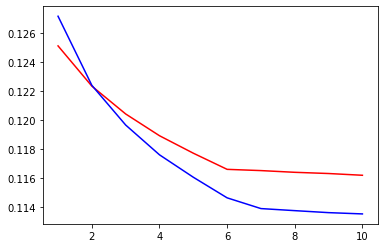

In [ ]:
plt.plot([1,2,3,4,5,6,7,8,9,10],losses['val'], 'r')
plt.plot([1,2,3,4,5,6,7,8,9,10],losses['train'], 'b')
plt.show()

In [ ]:
torch.save(model_extractor.state_dict(), 'resnet18.pth')

In [ ]:
model_save_name = 'efficientnet_b0.pth'
path = f"./drive/MyDrive/CLEANCODECUP/{model_save_name}" 
torch.save(model_extractor.state_dict(), path)

# Инференс модели

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# use_gpu = torch.cuda.is_available()

In [ ]:
test = pd.read_csv('test.csv')
test.head()

,class_id,image
0,NaN,mwiNS62kZXUEJARdf3rxCpI0VztLO1B7guKTDGMj.jpg
1,NaN,Dvtu5QLrVFq0JxjlcgmK94n3SC68iAphHXoBfzYM.jpg
2,NaN,mldYZ9OiXh5P0ERHNcKLp78SbMtfkBx2rwJeszoa.jpg
3,NaN,tZaCF4XK2hPLTlW8YRdAnMD5mfSxzBujwVpUJ7b0.jpg
4,NaN,73gEZNzIV9SLcf14wkrTYUoHJOMuDetsvihP0mAq.jpg


In [ ]:
!unzip drive/MyDrive/CLEANCODECUP/images.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images/W1rt2sIYTvD7KdBQbJEMgcHCjSOh0Xp84NumioL3.jpg  
  inflating: images/w1S2xfcJqDRUPyBe0s7aMuE8Qv5AkTzhHNZOIb6F.jpg  
  inflating: images/W1syljB3uz9PpqOTYxM5SmgEo2H7Xk8LceUCnwa0.jpg  
  inflating: images/w1TfH4oYxsNpZK7kjEiQ0bcmgLedz8Oy5BrvAPD2.jpg  
  inflating: images/W1Tx9HyXCG3JIkbu7O62zpZ5hUfFrMKS0Ddnj8AV.jpg  
  inflating: images/w1xJKZERM4FzS6gtOTdnrC8sHUG2qabkX0uAYi5L.jpg  
  inflating: images/w1YH3jIKMzpq5nbS2a7d8uORJcXPstZC9vy40grA.jpg  
  inflating: images/W1YnK9PmBGwgEhXUSCOIN8TAR5lV7vcZypobxLMa.jpg  
  inflating: images/W23Xk9DMeJlOh5F4jAYgpdQcvq6RVyI7EHb8C10x.jpg  
  inflating: images/w24DWZoLTzcaJAHFyQ05mOYkM6jUxurEBgVbhe1v.jpg  
  inflating: images/W253VhY8wpGoKuXy4bCjv6TaDNfR1dAq0zJmLnZl.jpg  
  inflating: images/w28JXnBtYrlfdPC5vQH9A4exUoEN7ypKaksViRhW.jpg  
  inflating: images/w298kA3YaCmpGMuUK5o7siDctlgQJHe1xr6BXEnv.jpg  
  inflating: images/w2AiMKsDk0TojbgFtHZLQhvynU9lxcuO1BNJYSz6.

In [ ]:
import os
os.remove('./images/BunpXaDiFChjE79yHgcNz5kTMJZwlYQRmUIteK6A.jpg')

In [ ]:
classes_id = []

transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(244),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
SIZE_DELETE = 1000
PATH = './images/'
for index, row in tqdm(test.iterrows(),total=test.shape[0]):
    image_name = row['image']
#     print(os.path.getsize(f'images/images/{image_name}'))
    if os.path.exists(f'{PATH}{image_name}') and (os.path.getsize(f'{PATH}{image_name}') > SIZE_DELETE):
        image = Image.open(f'{PATH}{image_name}').convert('RGB')
        image = transform(image).unsqueeze(0)
        image = image.cuda()
    #     print(image_name)

        output = model_extractor(image)
        classes_id.append(torch.argmax(output, -1).item())
    else:
        classes_id.append(775)

  0%|          | 0/31718 [00:00<?, ?it/s]

In [ ]:
test['class_id'] = classes_id
test.to_csv('submit.csv', index=False)